In [5]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import skimage
from skimage.feature import canny
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line, rotate
import math
from scipy import ndimage
from matplotlib.path import Path

smart content aware noise removal could be one idea to improve.
working fine all images.
gaussianblur inbuilt works only on even window sizes

In [6]:
def find_scan_screenshot(img):
    # return 0 for scan/screenshot and 1 for photograph
    total_pixels = img.shape[0]*img.shape[1]
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    prop = np.sum(hist[15:241])/total_pixels
    if prop<0.1:
        return 0
    else:
        return 1

In [7]:
def binarization_scans(img):
    # using inbuilt otsu's method..Implement later
    _,im = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return im
#handle very small images later 
def binarization_photos(img):
    high_res = 0
    if img.size>2000*1000:
        high_res = 1
    
    if high_res==1:
        img = cv2.GaussianBlur(img,(9,9),3) # fails for even
    
    window_size = int(min(img.shape[0],img.shape[1])/60)
    if window_size%2==0:
        window_size+=1 #cv2.adaptiveThreshold accepts only odd window sizes
    
    thresh_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,window_size,10)
    return thresh_img

def morph_proc(img):
    img = 255 - img
    img[img==255] = 1
    kernel = np.ones((3,3))
    kernel1 = np.ones((5,5))
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel) 
    closed = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel) 
#     filled = cv2.morphologyEx(closed, cv2.MORPH_DILATE, kernel1) 
    fin_img = cv2.morphologyEx(closed, cv2.MORPH_DILATE, kernel1) 
#     hole_size = int(0.0005 * img.shape[0] * img.shape[1])
#     fin_img = remove_small_holes(fin_img, area_threshold=hole_size)
    fin_img[fin_img==1] = 255
    return 255 - fin_img

In [8]:
def binarize_input(img):
    img_type = find_scan_screenshot(img)
    if img_type==0:
        print("Scan/Screenshot")
    else:
        print("Photograph")
    if img_type==0:
        new_img = binarization_scans(img)
    else:
        new_img = binarization_photos(img)
        new_img = morph_proc(new_img)
    return new_img

In [9]:
def remove_small_noise(img):
    img[img==255] = 1
    hole_size = int(0.0005 * img.shape[0] * img.shape[1])
    new_img = remove_small_holes(img, area_threshold=hole_size)
    new_img[new_img==1] = 255
    return 255-new_img

In [10]:
# directory = "../input/"
# for filename in os.listdir("../input/"):
#     try:
#         img_name = os.path.join(directory, filename)
#         print(img_name)
#         img = cv2.imread(img_name,0)
#         plt.imshow(img,cmap='gray')
#         plt.show()
#         new_img = binarize_input(img)
#         plt.imshow(new_img,cmap='gray')
#         plt.show()
#     except :
#         pass
    
# remove very small images maybe based on area after connected comp analysis

In [11]:
def skew_correction(img):
    neg_img = 255 - img
    img_edges = canny(neg_img, sigma=7)
    h, theta, d = hough_line(img_edges)
    h, theta, d = hough_line_peaks(h, theta, d, min_distance=0, min_angle=0, num_peaks=4)
    theta = [int(np.round(math.degrees(i))) for i in theta]    
    print(theta)

    dom_orient = max(theta)
    deskewing_angle = dom_orient - 90

    while abs(deskewing_angle) > 45: 
        deskewing_angle = deskewing_angle - (abs(deskewing_angle)/deskewing_angle) * 90

    print(deskewing_angle)
    deskew_img = skimage.transform.rotate(new_img, deskewing_angle, resize=True, cval=1, mode ='constant')
    
    return deskew_img.astype(np.uint8)

In [12]:
# directory = "../input/"
# for filename in os.listdir("../input/"):
#     try:
#         img_name = os.path.join(directory, filename)
#         img = cv2.imread(img_name,0)
#         plt.imshow(img,cmap="gray")
#         plt.show()
#         plt.imshow(skew_correction(binarize_input(img)),cmap="gray")
#         plt.show()
#     except:
#         pass
# img = cv2.imread("../input/eq5_hr.jpg",0)
# new_img = binarize_input(img)
# img_rotated = skew_correction(new_img)
# plt.imshow(im,cmap='gray')

In [13]:
# img = cv2.imread("../input/eq5_hr.jpg",0)
# plt.imshow(img,cmap='gray')
# plt.show()
# new_img = binarize_input(img)
# img_rotated = skew_correction(new_img)
# plt.imshow(img_rotated,cmap='gray')
# plt.show()

In [14]:
def check_contains(bbox1, bbox2): 
    '''check if bbox2 is contained in bbox1'''
    if (bbox1[0]<bbox2[0]) and (bbox1[2]>bbox2[2]) and (bbox1[1]<bbox2[1]) and (bbox1[3]>bbox2[3]):
        return True
    return False
    

In [15]:
def segmentation(im):
    plt.imshow(im,cmap='gray')
    plt.show()
    neg_im = 1-im
    kernel = np.ones((3,3), np.uint8) 
    neg_im_erosion = cv2.erode(neg_im, kernel, iterations=1) 
    edge_map = np.logical_xor(neg_im,neg_im_erosion)
    plt.imshow(edge_map,cmap="gray")
    plt.show()
    labels = skimage.measure.label(edge_map, connectivity=2) #connectivity-2 => neighbours 8
    reg = skimage.measure.regionprops(labels)
#     print(len(reg))
    bboxs = [i.bbox for i in reg] #min_row, min_col, max_row, max_col
    centroids = [i.centroid for i in reg]
    convex_hulls = [i.convex_image for i in reg]
    imgs = [i.image for i in reg]
    ign_ind = []
    # checking if bounding box is contained, need to change to, convex hull being contained - vivek
#     need to add additional check with edge map
    for i in range(0,len(bboxs)): #checks if 'j' is contained in 'i'
        for j in range(0,len(bboxs)):
            if bboxs[i]==bboxs[j]:
                continue
            
            contains = check_contains(bboxs[i],bboxs[j])
            if contains:
                ign_ind.append(j)
                
    
#     for i in ign_ind:
#         print(bboxs[i])
#         plt.imshow(im[bboxs[i][0]:bboxs[i][2],bboxs[i][1]:bboxs[i][3]],cmap='gray')
#         plt.show()
#     plt.imshow(imgs[i],cmap=plt.cm.gnuplot)
    centroids_new = []
    bboxs_new = []
    convex_hulls_new = []
    imgs_new = []
    imgs_sizes = []
    for i in range(0,len(imgs)):
        if i in ign_ind:
            print(i,"hai")
            continue
        elif imgs[i].size<1000: #theshold of 1000 on segmented part sizes to get rid of extra noisy stuff
            continue
        centroids_new.append(centroids[i])
        bboxs_new.append(bboxs[i])
        convex_hulls_new.append(convex_hulls[i])
        imgs_new.append(imgs[i])
        imgs_sizes.append(imgs[i].size)
#         plt.imshow(imgs[i],cmap="gray")
#         plt.show()
    
    imgs_sizes = np.sort(imgs_sizes)
    print(imgs_sizes)
    return centroids_new, bboxs_new, convex_hulls_new, imgs_new

In [16]:
# img = cv2.imread("../input/eq5_hr.jpg",0)
# plt.imshow(img,cmap='gray')
# plt.show()
# new_img = binarize_input(img)
# img_rotated = skew_correction(new_img)
# plt.imshow(img_rotated,cmap='gray')
# plt.show()
# centroids, bboxs, convex_hulls,imgs = segmentation(img_rotated)
# centroids_new = []
# for i in range(0, len(imgs)):
#     plt.imshow(imgs[i],cmap='gray')
#     centrs = [centroids[i][0],centroids[i][1]]
#     centrs[0]-=bboxs[i][0]
#     centrs[1]-=bboxs[i][1]
#     print(centrs)
#     centroids_new.append(centrs)
#     plt.show()

In [49]:
def create_identifier(img,centroid):
    #assuming that the character pixels in the paper means those pixels belonging to character
    id_profile = np.zeros(22)
    mom_inertia = 0
    char_count = 0
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            if img[i,j] != 0:
                char_count+=1
                mom_inertia+=(i-centroid[0])**2+(j-centroid[1])**2
    mom_inertia/=(char_count**2)
    id_profile[0] = mom_inertia
    img[img==255] = 1
    mu00 = central_moments(img,0,0)
    etas = np.zeros((4,4))
    for p in range(0,4):
        for q in range(0,4):
            if p+q<=3:
                gamma = 1 + (p+q)/2
                etas[p,q] = central_moments(img,p,q)/(mu00**gamma)

    hu2 = (etas[2,0] - etas[0,2])**2 + (4*etas[1,1]**2)
    hu3 = (etas[3,0] - 3*etas[1,2])**2 + (3*etas[2,1] - etas[0,3])**2
    hu4 = (etas[3,0] + etas[1,2])**2 + (etas[2,0] + etas[0,3])**2
    hu5 = (etas[3,0] - 3*etas[1,2])*(etas[3,0] + etas[1,2])*((etas[3,0] + etas[1,2])**2 - 3*((etas[2,1] + etas[0,3])**2)) + (3*(etas[2,1] - etas[0,3]))*(etas[2,1] + etas[0,3])*(3*(etas[3,0] + etas[1,2])**2 - (etas[2,1] + etas[0,3])**2)
    hu6 = (etas[2,0] - etas[0,2])*((etas[3,0]+etas[1,2])**2 - (etas[2,1]+ etas[0,3])**2) + 4*etas[1,1]*((etas[3,0] + etas[1,2])*(etas[2,1] + etas[0,3]))
    hu7 = (3*etas[2,1] - etas[0,3])*(etas[3,0] + etas[1,2])*((etas[3,0] + etas[1,2])**2 - 3*(etas[2,1]-etas[0,3])**2) - (etas[3,0] - 3*etas[1,2])*(etas[2,1] + etas[0,3])*(3*(etas[3,0] + etas[1,2])**2 - (etas[2,1] + etas[0,3])**2)
    id_profile[16] = hu2
    id_profile[17] = hu3
    id_profile[18] = hu4
    id_profile[19] = hu5
    id_profile[20] = hu6
    id_profile[21] = hu7
    id_profile[1:16] = get_circular_topology(img,centroid)
    return id_profile

In [18]:
def central_moments(img, p, q):
    img[img==255] = 1
    M00 = 0 
    M10 = 0
    M01 = 0
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            M00+=img[i,j]
            M10+=i*img[i,j]
            M01+=j*img[i,j]
    
    x_bar = np.floor(float(M10)/float(M00))
    y_bar = np.floor(float(M01)/float(M00))
    
    cen_mmt = 0
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            cen_mmt += ((i-x_bar)**p)*((j-y_bar)**q)*img[i,j]
            
    return cen_mmt

In [19]:
def create_new_centroids(centroids,bboxs,ims):
    centroids_new = []
    for i in range(0, len(ims)):
        plt.imshow(ims[i],cmap='gray')
        centrs = [centroids[i][0],centroids[i][1]]
        centrs[0]-=bboxs[i][0]
        centrs[1]-=bboxs[i][1]
        print(centrs)
        centroids_new.append(centrs)
        plt.show()
    return centroids_new

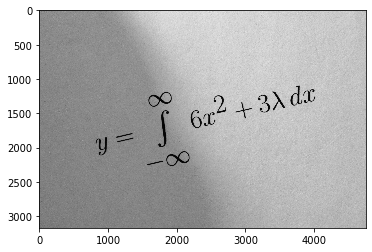

Photograph
[77, 77, 77, 77]
-13


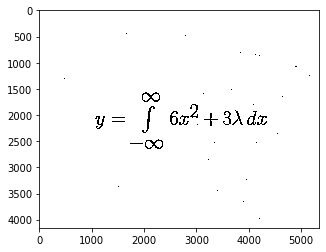

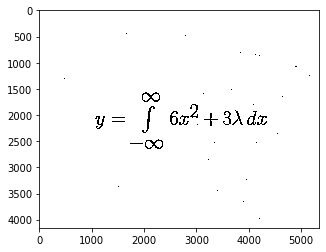

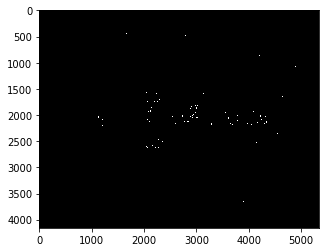

42 hai
43 hai
60 hai
62 hai
67 hai
68 hai
79 hai
80 hai
[  6552   6615   6804  35868  35868  41291  41426  43040  47288  53010
  54795  63712  63750  63882 136234]
[89.39204126750178, 175.96978629329396]


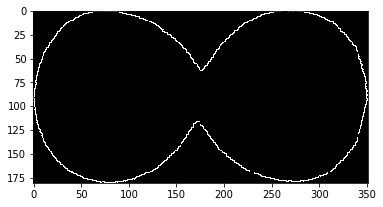

[138.5851763299463, 80.84638374178121]


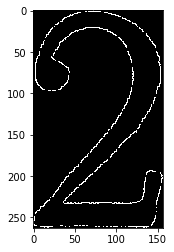

[260.01917098445574, 132.17772020725397]


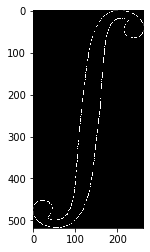

[165.08867362146066, 100.73994038748151]


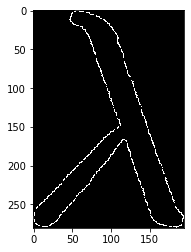

[156.444362017804, 114.22774480712178]


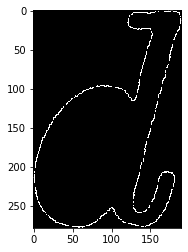

[114.6049004594181, 75.95788667687611]


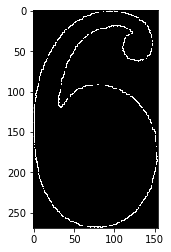

[135.09859154929563, 82.42077464788736]


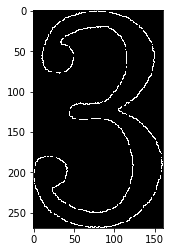

[124.72226656025532, 127.1372705506783]


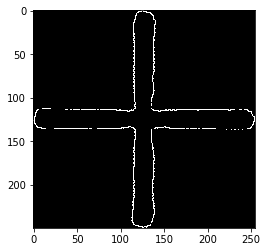

[124.01193058568333, 80.8731019522777]


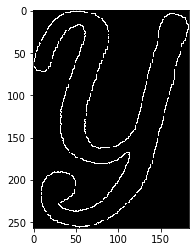

[90.42124999999987, 97.05999999999995]


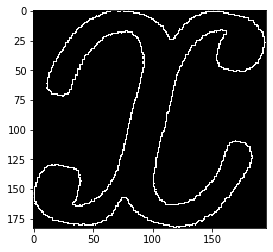

[90.07640172520041, 97.20147874306804]


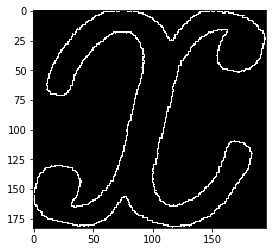

[13.23265895953773, 126.30635838150283]


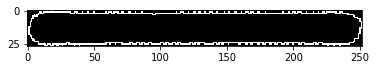

[12.2621502209131, 125.93961708394704]


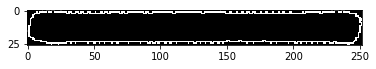

[90.26792179580025, 174.79217958001436]


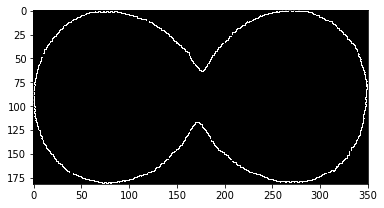

[12.769817073170543, 121.53963414634154]


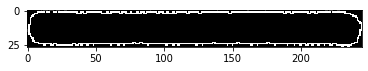

128 183
52 186
51 168
126 164


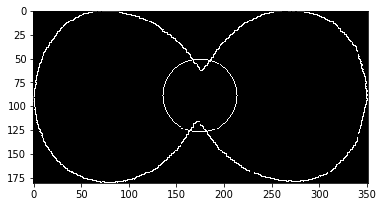

4
145 194
35 199
35 154
143 152


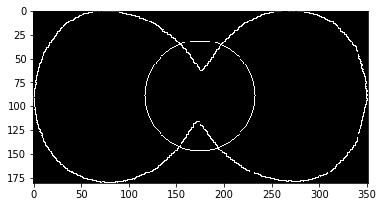

In [ ]:
img = cv2.imread("../input/eq8_hr.jpg",0)
plt.imshow(img,cmap='gray')
plt.show()
new_img = binarize_input(img)
img_rotated = skew_correction(new_img)
plt.imshow(img_rotated,cmap='gray')
plt.show()
centroids, bboxs, convex_hulls,imgs = segmentation(img_rotated)
centroids_new = create_new_centroids(centroids, bboxs, imgs)
prof = create_identifier(imgs[0],centroids_new[0])
print(prof)

136 136
115 138


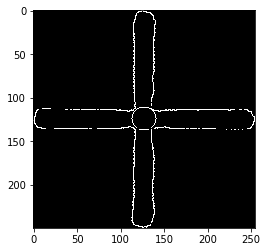

2
152 136
134 154
115 154
98 137
99 116
115 101
134 101
150 116


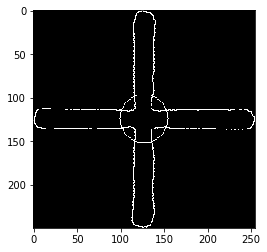

8
166 138
135 168
114 168
84 138
84 116
113 86
135 86
165 116


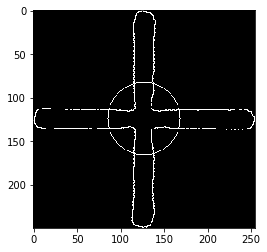

8
180 138
136 183
114 183
70 139
69 115
113 72
136 72
180 115


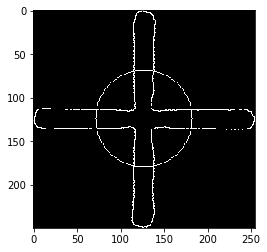

8
195 137
136 197
114 197
55 139
55 116
114 57
135 57
194 115


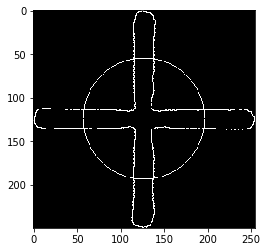

8
209 137
136 211
114 211
41 138
41 116
114 43
135 43
209 116


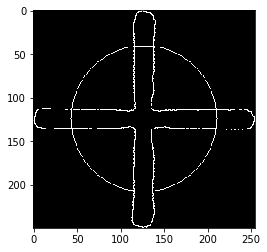

8
223 138
136 225
115 226
27 139
26 116
113 29
135 29
223 114


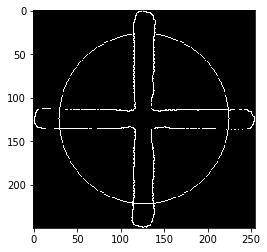

8
237 138
137 240
113 240
12 140
12 116
112 15
136 15
237 113


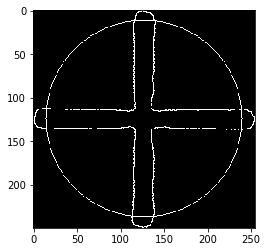

8


array([2.        , 8.        , 8.        , 8.        , 8.        ,
       8.        , 8.        , 8.        , 1.64979442, 0.91655246,
       1.06669248, 1.18540784, 1.26920692, 1.31983554, 1.35126019])

In [55]:
def ang_dist(xx,yy):
    lis = [] 
    for x,y in zip(xx,yy):
        delta = np.abs(x-y)
        if delta > np.pi:
            delta = 2*np.pi-delta 
        lis.append(delta)
    return max(lis)
def circular_mask(img,centroid,radius):
    lastx,lasty = -10,-10
    last = 0
    count = 0
    cut_angles = []
    img = img.astype(np.uint8)
    angle = np.linspace(0,2*np.pi,3600)
    circle_x = np.rint(centroid[0]+radius*np.cos(angle)).astype(np.int64)
    circle_y = np.rint(centroid[1]+radius*np.sin(angle)).astype(np.int64)  
    for x,y,theta in zip(circle_x,circle_y,angle):
        try :
            if img[x,y] != last :
                last = img[x,y]
                if img[x,y] == 1 and abs(lastx-x)+abs(lasty-y)>15:
                    count += 1
                    lastx,lasty = x,y
                    cut_angles.append(theta)
                    print(x,y)
        except:
            pass
    if count == 0:
        return 0,0
    cut_angles = np.asarray(cut_angles)
    angular_distance = ang_dist(np.roll(cut_angles,1),cut_angles)
    cv2.circle(img,(int(centroid[1]),int(centroid[0])),int(radius),1,thickness=1)
    plt.imshow(img,cmap="gray")
    plt.show()
    print(count)
    return count,angular_distance
def get_circular_topology(img,centroid):
    circular_topology = np.zeros(16)
    #finding maximum distance
    edge_indices = np.argwhere(img)
    d=np.sqrt(np.max(np.sum((edge_indices-centroid)**2,axis=1)))/9
    for i in range(1,9):
        circular_topology[i-1],circular_topology[7+i] = circular_mask(img,centroid,i*d)
    return circular_topology[:-1]
get_circular_topology(imgs[7],centroids_new[7])


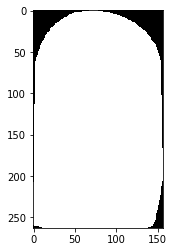

In [34]:
plt.imshow(convex_hulls[1],cmap="gray")